# Various methods of community detection

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import string
import random
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 

import community
# import jgraph as igraph
import leidenalg
import igraph as ig
import oslom

Nodes: 34
Edges: 78
Is connected True


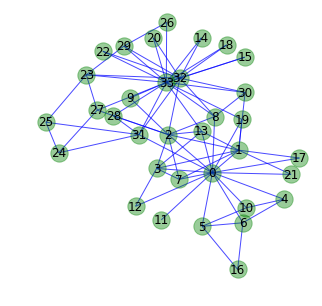

In [19]:
# n=30
# p=0.15
# G=nx.erdos_renyi_graph(n,p)

G=nx.karate_club_graph()

print "Nodes:",len(G.nodes())
print "Edges:",len(G.edges())
print "Is connected",nx.is_connected(G)

pos=graphviz_layout(G);

plt.figure(figsize=(5,5));
nodes = nx.draw_networkx_nodes(G, pos, node_color="g", alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
nx.draw_networkx_labels(G, pos)
plt.axis('off');

## 1. Louvain algorithm

In [20]:
partition = community.best_partition(G)

kk=len(set(partition.values()))
print 'The graph has', kk, 'Louvain communities'
cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])

The graph has 4 Louvain communities
Community 0 with 13 nodes: [8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]
Community 1 with 12 nodes: [0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21]
Community 2 with 5 nodes: [4, 5, 6, 10, 16]
Community 3 with 4 nodes: [24, 25, 28, 31]


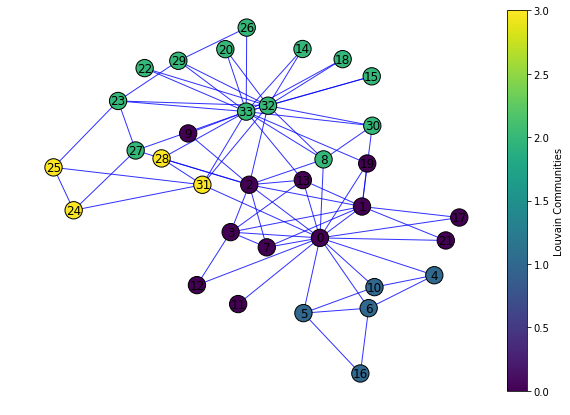

In [21]:
node_color=partition.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = nx.spring_layout(G, iterations=1000) #graphviz_layout(G)
node_border_color='k'
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')

## 2. Leiden algorithm

In [22]:
g = ig.Graph(directed=False)
g.add_vertices(G.nodes())
g.add_edges(G.edges())

partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);

kk=len(list(partition))
print 'The graph has', kk, 'Leiden communities'
cml=list(partition)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])

The graph has 4 Leiden communities
Community 0 with 12 nodes: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
Community 1 with 11 nodes: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2 with 6 nodes: [23, 24, 25, 27, 28, 31]
Community 3 with 5 nodes: [4, 5, 6, 10, 16]


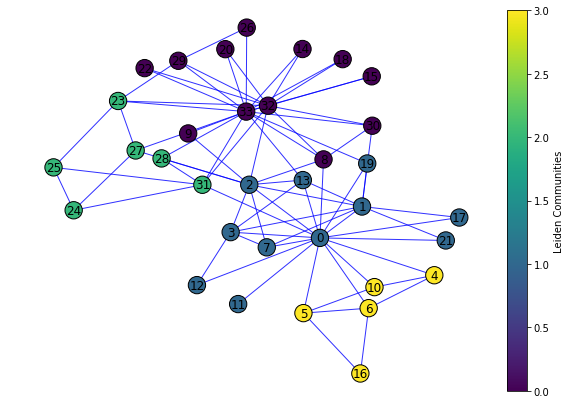

In [23]:
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i

node_color=partd.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = nx.spring_layout(G, iterations=1000) #graphviz_layout(G)
node_border_color='k'
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Leiden Communities") #, orientation='horizontal')

### Robotics Data

In [7]:
df = pd.read_csv("nodes_edges.csv", dtype='unicode')
print "Number of rows =", len(df)
df.head(10)

Number of rows = 419986


,Node1,Node2,Weight
0,0,1,425
1,0,2,385
2,0,3,364
3,0,4,331
4,0,5,315
5,0,6,320
6,0,7,316
7,0,8,306
8,0,9,296
9,0,10,307


In [8]:
# sdf=df.sample(frac=0.00011)
# print "Number of sampled rows =", len(sdf)
# sdf.head(10)

In [9]:
# eds=[]
# for i in range(len(sdf)):
#     a=sdf.iloc[i]["Node1"]
#     b=sdf.iloc[i]["Node2"]
#     c=sdf.iloc[i]["Weight"]
#     eds.append((int(a),int(b),int(c)))
# len(eds)

In [10]:
# G = nx.Graph()
# G.add_weighted_edges_from(eds)

# print len(G.nodes()) #, 'nodes:', G.nodes() 
# print len(G.edges()) #, 'edges:', G.edges(data=True)
# print "Is connected",nx.is_connected(G)
# print "number of connected components =", nx.number_connected_components(G)
# giant = max(nx.connected_component_subgraphs(G), key=len)
# print "Giant connected component", len(giant.nodes()),len(giant.edges())

In [11]:
# pos=graphviz_layout(G);

# plt.figure(figsize=(5,5));
# nodes = nx.draw_networkx_nodes(G, pos, node_color="g", alpha=0.4)
# nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
# nx.draw_networkx_labels(G, pos)
# plt.axis('off');

In [12]:
while True:
    sdf=df.sample(frac=0.001)
    eds=[]
    for i in range(len(sdf)):
        a=sdf.iloc[i]["Node1"]
        b=sdf.iloc[i]["Node2"]
        c=sdf.iloc[i]["Weight"]
        eds.append((int(a),int(b),int(c)))
    G = nx.Graph()
    G.add_weighted_edges_from(eds)
#     if len(G.nodes())<500:
    giant = max(nx.connected_component_subgraphs(G), key=len)
    if nx.is_tree(giant)==False:
#     if len(giant.nodes())<100:
        break

In [13]:
print len(G.nodes()) #, 'nodes:', G.nodes() 
print len(G.edges()) #, 'edges:', G.edges(data=True)
print "Is connected",nx.is_connected(G)
print "number of connected components =", nx.number_connected_components(G)
giant = max(nx.connected_component_subgraphs(G), key=len)
print "Giant connected component", len(giant.nodes()),len(giant.edges())
print nx.is_tree(giant)

532
420
Is connected False
number of connected components = 115
Giant connected component 108 110
False


False


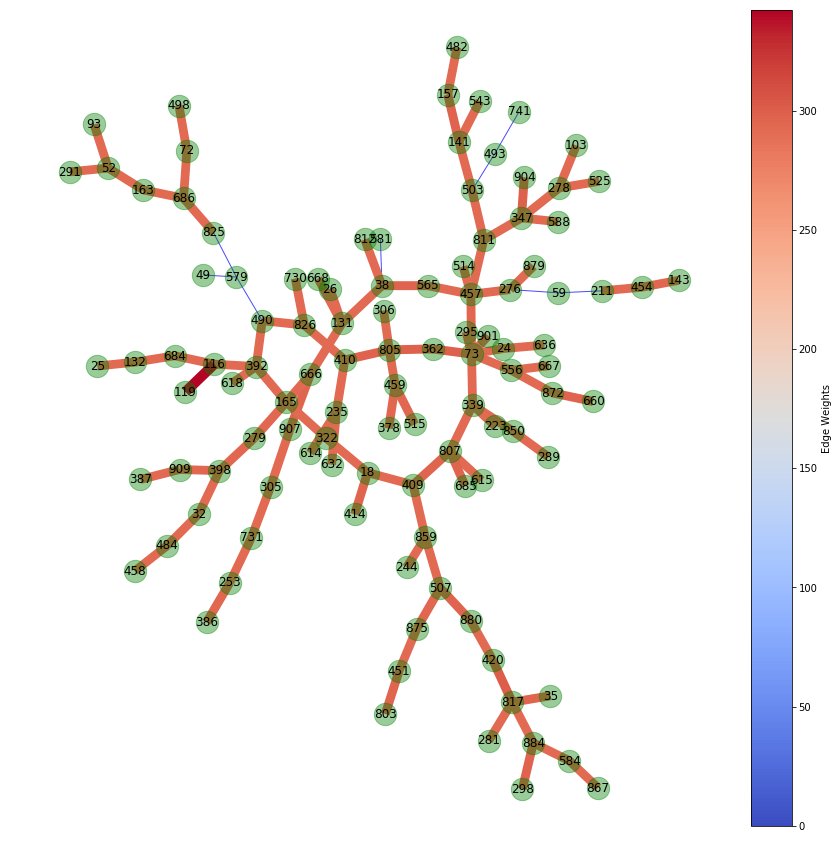

In [14]:
G=giant
print nx.is_tree(G)

elabels={}
elabels = nx.get_edge_attributes(G,'weight')

weight_list = [ e[2]['weight'] for e in G.edges(data=True) ]

cmap_e=plt.cm.coolwarm #plt.cm.tab20b 
# edge_color=weight_list
vmin_e = min(weight_list) 
vmax_e = max(weight_list) 

width_list=[0.03*w for w in weight_list]

pos=graphviz_layout(G);

plt.figure(figsize=(15,15));
nodes = nx.draw_networkx_nodes(G, pos, node_size=500,node_color="g", alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);
plt.axis('off');

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)

In [15]:
partition = community.best_partition(G)

kk=len(set(partition.values()))
print 'The graph has', kk, 'Louvain communities'
cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])

The graph has 16 Louvain communities
Community 0 with 13 nodes: [515, 805, 306, 826, 614, 632, 378, 362, 410, 459, 730, 490, 235]
Community 1 with 13 nodes: [35, 298, 584, 867, 880, 281, 420, 875, 884, 451, 803, 817, 507]
Community 2 with 12 nodes: [525, 278, 543, 811, 588, 141, 103, 157, 347, 904, 482, 503]
Community 3 with 11 nodes: [18, 279, 32, 322, 387, 909, 398, 414, 165, 458, 484]
Community 4 with 10 nodes: [289, 850, 339, 859, 615, 409, 685, 244, 223, 807]
Community 5 with 9 nodes: [556, 24, 295, 73, 872, 636, 901, 660, 667]
Community 6 with 9 nodes: [131, 26, 386, 907, 668, 666, 305, 731, 253]
Community 7 with 8 nodes: [291, 52, 825, 93, 163, 686, 72, 498]
Community 8 with 8 nodes: [514, 276, 38, 812, 565, 581, 879, 457]
Community 9 with 7 nodes: [25, 618, 116, 119, 132, 392, 684]
Community 10 with 3 nodes: [143, 454, 211]
Community 11 with 1 nodes: [741]
Community 12 with 1 nodes: [59]
Community 13 with 1 nodes: [579]
Community 14 with 1 nodes: [49]
Community 15 with 1 nodes:

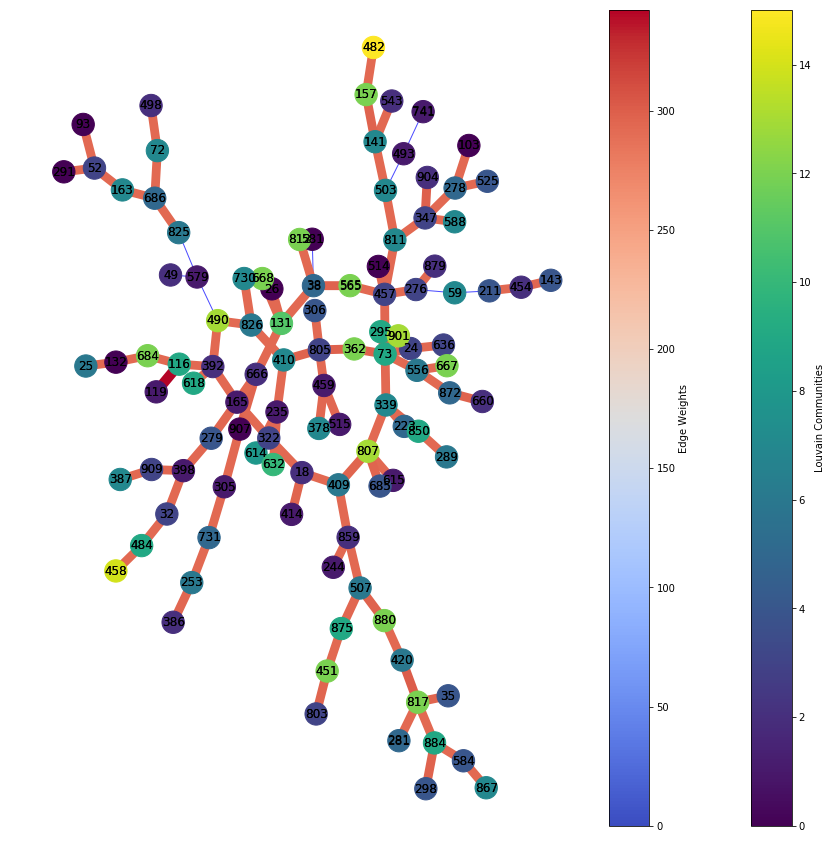

In [16]:
node_color=partition.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

# edge_color=weight_list
# vmin_n = min(edge_color) #df['color'].min()
# vmax_n = max(edge_color) #df['color'].max()
# cmap_n=plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(15,15));

nodes = nx.draw_networkx_nodes(G, pos, node_size=500,node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);

plt.axis('off');
yoffset = {}
y_off = -0.08  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)

In [17]:
g = ig.Graph(directed=False)

nodelist = list(G.nodes())
nodelist.sort()
mapping = {old_label:new_label for new_label, old_label in enumerate(G.nodes())}
# invmap={v:k for k,v in mapping.items()}
H = nx.relabel_nodes(G, mapping)

g.add_vertices(H.nodes())
g.add_edges(H.edges())

partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);

mpart=[]
for i in list(partition):
    t=[]
    for j in i:
        for k,v in mapping.items():
            if v==j:
                t.append(k)
    mpart.append(t)

kk=len(list(partition))
print 'The graph has', kk, 'Leiden communities'
cml=mpart

cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])

The graph has 11 Leiden communities
Community 0 with 14 nodes: [525, 543, 588, 904, 103, 141, 157, 741, 278, 811, 347, 482, 493, 503]
Community 1 with 13 nodes: [24, 556, 73, 636, 660, 667, 295, 223, 289, 850, 339, 872, 901]
Community 2 with 12 nodes: [514, 38, 565, 59, 581, 143, 211, 276, 812, 879, 454, 457]
Community 3 with 10 nodes: [25, 49, 579, 618, 116, 119, 132, 684, 392, 490]
Community 4 with 10 nodes: [615, 685, 859, 244, 803, 807, 875, 409, 451, 507]
Community 5 with 9 nodes: [26, 131, 666, 668, 731, 253, 305, 386, 907]
Community 6 with 9 nodes: [35, 584, 281, 298, 867, 880, 884, 420, 817]
Community 7 with 9 nodes: [515, 730, 805, 306, 826, 362, 378, 410, 459]
Community 8 with 8 nodes: [52, 93, 163, 686, 291, 825, 72, 498]
Community 9 with 8 nodes: [32, 165, 279, 387, 909, 398, 458, 484]
Community 10 with 6 nodes: [18, 614, 632, 235, 322, 414]


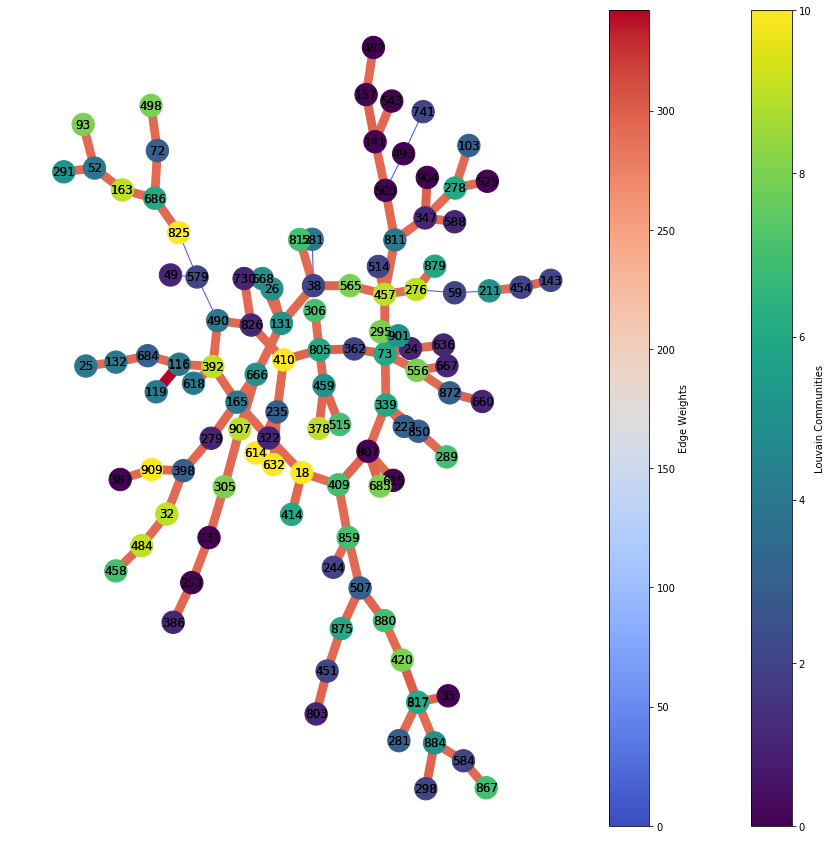

In [18]:
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
        
node_color=partd.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

# edge_color=weight_list
# vmin_n = min(edge_color) #df['color'].min()
# vmax_n = max(edge_color) #df['color'].max()
# cmap_n=plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(15,15));

nodes = nx.draw_networkx_nodes(G, pos, node_size=500,node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);

plt.axis('off');
yoffset = {}
y_off = -0.08  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)
